<!--
 * @file        5_radar.ipynb
 * @brief       This notebook provides Radar data processing and analysis.
 *
 * @authors     Jaehwan Lee (idljh5529@gmail.com)
 *
 * @date        2025-08-12 Released by AI Lab, Hanyang University
 *
-->

# 5. Radar (RAdio Detection And Ranging)

이번 실습에서는 실제 취득한 Radar 포인트 클라우드 데이터를 분석해보고, 해당 데이터들을 처리하는 몇 가지 방법에 대해 실습을 진행합니다.

## 실습 목표
1. 실제 취득한 Radar 데이터 시각화 및 분석
2. Noise Filtering 실습
3. Transformation 실습
4. Clustering 실습

In [1]:
# 외부에 정의된 파이썬 모듈(.py 파일)을 수정할 때마다 매번 커널을 재시작하지 않아도 변경 사항이 자동으로 반영되도록 설정
%load_ext autoreload
%autoreload 2

In [2]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from tutlibs.radar.custom_radar import RadarDataLoader, RadarVisualizer
import time
import copy

# Check Open3D version
print(f"Open3D version: {o3d.__version__}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Open3D version: 0.17.0


## 1. Radar 데이터 시각화 및 분석

실제 여러 가지 Radar를 통해 취득한 포인트 클라우드 데이터를 시각화하고 분석하겠습니다.

### 1-1. 3D Radar

일반적인 radar는 Range, azimuth 값을 통해 **x**, **y** 값과 **doppler velocity** 값을 출력합니다.

In [3]:
# 데이터 로더 초기화
data_loader = RadarDataLoader()

# 포인트클라우드 데이터 로딩
pcd_folder_path = "./../data/radar_pcd"  # 실제 PCD 파일들이 있는 폴더
point_clouds = data_loader.load_radar_pcd_files(pcd_folder_path)

print(f"📊 로딩된 데이터:")
print(f"   - 포인트클라우드: {len(point_clouds)}개 프레임")

📡 6개의 레이더 PCD 파일을 로딩 중...
로딩 진행률: 1/6 (16.7%)
   velocity field: ✅
✅ 6개의 포인트클라우드 로딩 완료
📊 로딩된 데이터:
   - 포인트클라우드: 6개 프레임


In [4]:
# 1-2. 첫 번째 데이터 시각화
print("=== 첫 번째 데이터 시각화 ===")

# 레이더 시각화 클래스 초기화
radar_visualizer = RadarVisualizer()

# 첫 번째 데이터 시각화
if point_clouds:
    print("첫 번째 데이터를 Open3D 창에서 확인하세요...")
    radar_visualizer.visualize_single_frame(point_clouds[0], frame_idx=0, visualize_coordinate_frame=False)
    
    # 첫 번째 프레임 정보 출력
    first_pcd = point_clouds[0]
    print(f"\n첫 번째 프레임 정보:")
    print(f"   - 포인트 수: {len(first_pcd.points)}")
    print(f"   - 컬러 정보: {'있음' if first_pcd.has_colors() else '없음'}")
else:
    print("⚠️ 로딩된 포인트클라우드가 없습니다.")

=== 첫 번째 데이터 시각화 ===
첫 번째 데이터를 Open3D 창에서 확인하세요...
📊 프레임 0 시각화 중...

첫 번째 프레임 정보:
   - 포인트 수: 64
   - 컬러 정보: 있음


### 1-2. 4D Radar

4D radar는 **x**, **y**, **doppler velocity** 값 뿐만 아니라, elevation 속성을 통한 **z**축의 값도 출력합니다.

In [5]:
# 4d imaging radar 데이터 시각화
if point_clouds:
    print("4d imaging radar 데이터를 Open3D 창에서 확인하세요...")
    radar_visualizer.visualize_single_frame(point_clouds[4], frame_idx=4)
    
    # 다섯 번째 프레임 정보 출력
    fifth_pcd = point_clouds[4]
    print(f"\n다섯 번째 프레임 정보:")
    print(f"   - 포인트 수: {len(fifth_pcd.points)}")
    print(f"   - 컬러 정보: {'있음' if fifth_pcd.has_colors() else '없음'}")
else:
    print("⚠️ 로딩된 포인트클라우드가 없습니다.")

4d imaging radar 데이터를 Open3D 창에서 확인하세요...
📊 프레임 4 시각화 중...

다섯 번째 프레임 정보:
   - 포인트 수: 241
   - 컬러 정보: 있음


In [7]:
# VLP 32C LiDAR 와 비교
vlp32c_pcd = o3d.io.read_point_cloud("../data/lidar_pcd/vlp32c_1679319638860873.pcd") # AILAB point cloud data
vlp32c_pcd_colored = vlp32c_pcd.paint_uniform_color([0, 1, 0])
radar_pcd_colored = point_clouds[4].paint_uniform_color([0, 0, 1])

# 두 포인트 클라우드를 시각화
o3d.visualization.draw_geometries([vlp32c_pcd_colored, radar_pcd_colored])

## 2. Noise Filtering (노이즈 필터링)

포인트 클라우드의 Noise Filtering은 포인트 클라우드에서 불필요한 노이즈 포인트들을 제거하는 것을 의미합니다. Noise Filtering을 사용하는 이유는 다음과 같습니다:

- **데이터 품질 향상**: 스캐닝 과정에서 발생하는 노이즈, 센서 오류, 반사 문제 등으로 인한 불정확한 점들을 제거하여 데이터의 신뢰성을 높입니다.
- **처리 복잡도 감소**: 노이즈 포인트들은 후속 처리 알고리즘에 방해가 될 수 있습니다. 이를 제거하면 알고리즘 성능을 향상시킬 수 있습니다.
- **메모리 효율성**: 불필요한 점들을 제거하여 메모리 사용량을 줄이고 처리 속도를 향상시킵니다.

이 절에서는 다음과 같은 노이즈 필터링 방법들을 소개합니다:
- **Statistical Outlier Removal** (통계적 이상점 제거)
  - 이웃 거리 분포 기반 필터링
  - 직접 구현한 KD-Tree 구현 사용
  - K-NN search 를 이용한 방법
- **Radius Outlier Removal** (반지름 기반 이상점 제거)
  - 반지름 내 이웃 개수 기반 필터링
  - 직접 구현한 KD-Tree 구현 사용
  - Radius search 를 이용한 방법
- **Open3D 내장 함수와의 비교**

### 2-1. Point cloud에 노이즈 추가

In [8]:
def add_noise_to_pointcloud(pcd, outlier_ratio=0.1, noise_std=0.05):
    """
    포인트 클라우드에 노이즈 추가
    
    Args:
        pcd: 원본 포인트 클라우드
        outlier_ratio: 전체 포인트 중 아웃라이어 포인트 비율 (0.0~1.0)
        noise_std: 가우시안 노이즈의 표준편차
    
    Returns:
        noisy_pcd: 노이즈가 추가된 포인트 클라우드
    """
    points = np.asarray(pcd.points)
    n_points = len(points)
    
    # 1. 기존 포인트에 가우시안 노이즈 추가
    noisy_points = points + np.random.normal(0, noise_std, points.shape)
    
    # 2. 완전한 아웃라이어 포인트 추가
    n_outliers = int(n_points * outlier_ratio)
    if n_outliers > 0:
        # 포인트 클라우드 바운딩 박스 계산
        min_bound = points.min(axis=0)
        max_bound = points.max(axis=0)
        
        # 바운딩 박스 확장하여 아웃라이어 생성
        range_expand = (max_bound - min_bound) * 0.5
        outlier_min = min_bound - range_expand
        outlier_max = max_bound + range_expand
        
        # 랜덤 아웃라이어 포인트 생성
        outliers = np.random.uniform(outlier_min, outlier_max, (n_outliers, 3))
        
        # 기존 포인트와 아웃라이어 결합
        all_points = np.vstack([noisy_points, outliers])
    else:
        all_points = noisy_points
    
    # 새로운 포인트 클라우드 생성
    noisy_pcd = o3d.geometry.PointCloud()
    noisy_pcd.points = o3d.utility.Vector3dVector(all_points)
    
    return noisy_pcd

pcd_clean = o3d.io.read_point_cloud("./../data/lidar_pcd/bunny_pc.ply")

# 노이즈가 추가된 포인트 클라우드 생성
np.random.seed(42)  # 재현 가능한 결과를 위해
pcd_noisy = add_noise_to_pointcloud(pcd_clean, outlier_ratio=0.15, noise_std=0.02)
print("Noisy Point Cloud:", len(pcd_noisy.points), "points")
print(f"Added {len(pcd_noisy.points) - len(pcd_clean.points)} outlier points")

# 노이즈가 추가된 포인트 클라우드 시각화
print("\n=== 노이즈가 추가된 포인트 클라우드 시각화 ===")
# Visualize bunny point cloud
o3d.visualization.draw_geometries([pcd_noisy], 
                                    window_name="Bunny Point Cloud",
                                    width=800, height=600)

Noisy Point Cloud: 4706 points
Added 613 outlier points

=== 노이즈가 추가된 포인트 클라우드 시각화 ===


In [9]:
### 원본과 노이즈 포인트 클라우드 비교 시각화 ###
pcd_clean_copy = o3d.geometry.PointCloud(pcd_clean)
pcd_noisy_copy = o3d.geometry.PointCloud(pcd_noisy)

# 색상 설정으로 구분
pcd_clean_copy.paint_uniform_color([0.0, 0.8, 0.0])  # 초록색 (깨끗한 데이터)
pcd_noisy_copy.paint_uniform_color([0.8, 0.0, 0.0])  # 빨간색 (노이즈 포함)

# translation으로 나란히 배치
pcd_noisy_copy.translate(np.array([1, 0, 0]))

print("=== 원본 vs 노이즈 비교 (나란히 배치) ===")
print("초록색: 원본 (깨끗한 데이터)")
print("빨간색: 노이즈가 추가된 데이터")

pcd_combined = pcd_clean_copy + pcd_noisy_copy
o3d.visualization.draw_geometries([pcd_combined], 
                                    window_name="Bunny Point Cloud",
                                    width=800, height=600)

=== 원본 vs 노이즈 비교 (나란히 배치) ===
초록색: 원본 (깨끗한 데이터)
빨간색: 노이즈가 추가된 데이터


### 2-2. Statistical Outlier Removal (통계적 이상점 제거) 
(KNN search를 이용한 방법)

Statistical Outlier Removal 방식은 각 포인트의 k-최근접 이웃들과의 평균 거리를 계산하고, 전체 포인트들의 거리 분포에서 통계적으로 벗어나는 점들을 제거합니다.

**알고리즘 원리:**
1. 각 점에 대해 k개의 최근접 이웃을 찾습니다 (KD-Tree 사용)
2. 각 점과 이웃들 간의 평균 거리를 계산합니다
3. 모든 평균 거리의 전역 평균(μ)과 표준편차(σ)를 계산합니다
4. μ ± (std_ratio × σ) 범위를 벗어나는 점들을 아웃라이어로 분류합니다
5. 아웃라이어를 제거한 깨끗한 포인트 클라우드를 반환합니다

이 방법은 우리가 구현한 커스텀 KD-Tree를 사용하여 교육 목적에 맞게 각 단계를 명확히 보여줍니다.


In [10]:
# for statistical outlier removal using custom KD-Tree
from tutlibs.radar.custom_radar import (
    StatisticalOutlierRemoval
)

print("커스텀 Statistical Outlier Removal 모듈이 성공적으로 로드되었습니다.")


커스텀 Statistical Outlier Removal 모듈이 성공적으로 로드되었습니다.


In [13]:
# 노이즈 포인트 클라우드를 원점으로 다시 이동 (이전 translation 되돌리기)
pcd_noisy.translate(np.array([-1, 0, 0]))

# 3D 포인트 클라우드를 NumPy 배열로 변환
points_3d = np.asarray(pcd_noisy.points)

print("=== 커스텀 KD-Tree를 사용한 Statistical Outlier Removal ===")
print(f"입력 포인트 수: {len(points_3d)}")

# Statistical Outlier Removal 파라미터 설정
nb_neighbors = 20
std_ratio = 0.5

print(f"파라미터: nb_neighbors={nb_neighbors}, std_ratio={std_ratio}")

# 커스텀 Statistical Outlier Removal 적용
filter_obj = StatisticalOutlierRemoval(nb_neighbors, std_ratio) # TODO: 커스텀 Statistical Outlier Removal 클래스 인스턴스의 인자 입력

# 필터링 실행 (자세한 로그와 함께)
start_time = time.time()
filtered_points, outlier_points = filter_obj.filter_points_sor(points_3d, return_outliers=True) # TODO: 커스텀 Statistical Outlier Removal 클래스의 filter_points_sor 함수 완성
processing_time = time.time() - start_time

print(f"\n=== 필터링 결과 ===")
print(f"처리 시간: {processing_time:.4f}초")
print(f"원본 포인트: {len(points_3d)}개")
print(f"필터링된 포인트: {len(filtered_points)}개")
print(f"제거된 아웃라이어: {len(outlier_points)}개")
print(f"아웃라이어 비율: {len(outlier_points)/len(points_3d)*100:.2f}%")


=== 커스텀 KD-Tree를 사용한 Statistical Outlier Removal ===
입력 포인트 수: 4706
파라미터: nb_neighbors=20, std_ratio=0.5
Applying Statistical Outlier Removal...
Parameters: nb_neighbors=20, std_ratio=0.5
Input points: 4706
Computing mean distances for 4706 points using custom KD-Tree...
Building KD-Tree structure...
KD-Tree built successfully in 0.0042s. Starting k-NN search for each point...
  Processed 100/4706 points (2.1%)
  Processed 200/4706 points (4.2%)
  Processed 300/4706 points (6.4%)
  Processed 400/4706 points (8.5%)
  Processed 500/4706 points (10.6%)
  Processed 600/4706 points (12.7%)
  Processed 700/4706 points (14.9%)
  Processed 800/4706 points (17.0%)
  Processed 900/4706 points (19.1%)
  Processed 1000/4706 points (21.2%)
  Processed 1100/4706 points (23.4%)
  Processed 1200/4706 points (25.5%)
  Processed 1300/4706 points (27.6%)
  Processed 1400/4706 points (29.7%)
  Processed 1500/4706 points (31.9%)
  Processed 1600/4706 points (34.0%)
  Processed 1700/4706 points (36.1%)
  Pr

In [14]:
# 3D 결과를 포인트 클라우드 객체로 변환
pcd_filtered = o3d.geometry.PointCloud()
pcd_filtered.points = o3d.utility.Vector3dVector(filtered_points)

pcd_outliers = o3d.geometry.PointCloud()
pcd_outliers.points = o3d.utility.Vector3dVector(outlier_points)

# 색상 설정
pcd_filtered.paint_uniform_color([0.0, 1.0, 0.0])  # 초록색 (인라이어)
pcd_outliers.paint_uniform_color([1.0, 0.0, 0.0])   # 빨간색 (아웃라이어)

### 필터링 결과 시각화 ###
print("\n=== Statistical Outlier Removal 결과 시각화 ===")
print("초록색: 필터링된 포인트 (인라이어)")
print("빨간색: 제거된 포인트 (아웃라이어)")

# 모든 포인트 함께 시각화
pcd_result_combined = pcd_filtered + pcd_outliers
o3d.visualization.draw_geometries([pcd_result_combined], 
                                    window_name="Statistical Outlier Removal Result",
                                    width=800, height=600)


=== Statistical Outlier Removal 결과 시각화 ===
초록색: 필터링된 포인트 (인라이어)
빨간색: 제거된 포인트 (아웃라이어)


In [15]:
### 필터링 전후 비교 시각화 ###
pcd_noisy_display = o3d.geometry.PointCloud(pcd_noisy)
pcd_filtered_display = o3d.geometry.PointCloud(pcd_filtered)

# translation으로 나란히 배치
pcd_filtered_display.translate(np.array([2, 0, 0]))

# 색상 설정
pcd_noisy_display.paint_uniform_color([1, 0.3, 0.3])    # 붉은색 (노이즈 포함)
pcd_filtered_display.paint_uniform_color([0.0, 0.8, 0.0]) # 초록색 (필터링됨)

print("\n=== 필터링 전후 비교 ===")
print("왼쪽 (빨간색): 필터링 전 (노이즈 포함)")
print("오른쪽 (초록색): 필터링 후 (깨끗한 데이터)")

pcd_before_after = pcd_noisy_display + pcd_filtered_display
o3d.visualization.draw_geometries([pcd_before_after], 
                                    window_name="Before vs After Filtering",
                                    width=800, height=600)


=== 필터링 전후 비교 ===
왼쪽 (빨간색): 필터링 전 (노이즈 포함)
오른쪽 (초록색): 필터링 후 (깨끗한 데이터)


### 2-3. Radius Outlier Removal (반지름 기반 이상점 제거)
Radius Outlier Removal 방식은 각 포인트 주변의 지정된 반지름 내에 있는 이웃 포인트의 개수를 세어, 최소 개수 이상의 이웃이 없는 점들을 제거합니다.

![Radius Outlier Removal](../resources/ch5/radius_outlier.webp)


**알고리즘 원리:**
1. 각 점을 중심으로 지정된 반지름의 구(sphere)를 만듭니다
2. 그 구 안에 있는 이웃 포인트의 개수를 셉니다  
3. 이웃 개수가 최소 임계값(min_nb_points) 미만인 점들을 아웃라이어로 분류합니다
4. 아웃라이어를 제거한 포인트 클라우드를 반환합니다

이 방법은 밀도 기반 필터링으로, 고립된 점들이나 밀도가 낮은 영역의 노이즈를 효과적으로 제거할 수 있습니다.


In [16]:
def custom_radius_outlier_removal(pcd, radius=0.05, min_nb_points=16):
    """
    커스텀 Radius Outlier Removal 구현
    
    Args:
        pcd: 입력 포인트 클라우드 (Open3D PointCloud 또는 numpy array)
        radius: 검색 반지름
        min_nb_points: 최소 이웃 포인트 개수
    
    Returns:
        filtered_pcd: 필터링된 포인트 클라우드
        outlier_indices: 제거된 아웃라이어 인덱스들
    """
    if isinstance(pcd, o3d.geometry.PointCloud):
        points = np.asarray(pcd.points)
    else:
        points = pcd
    
    print(f"Radius Outlier Removal 적용...")
    print(f"파라미터: radius={radius}, min_nb_points={min_nb_points}")
    print(f"입력 포인트 수: {len(points)}")
    
    # 각 포인트에 대해 반지름 내 이웃 개수 계산
    inlier_mask = np.zeros(len(points), dtype=bool)
    
    start_time = time.time()
    for i, point in enumerate(points):
        if i % 500 == 0 and i > 0:
            print(f"  처리 중... {i}/{len(points)} ({i/len(points)*100:.1f}%)")
        
        # 현재 점에서 모든 점까지의 거리 계산
        distances = np.linalg.norm(points - point, axis=1)
        
        # 반지름 내에 있는 이웃 포인트 개수 (자기 자신 제외)
        neighbors_in_radius = np.sum(distances < radius) - 1 # TODO: distances에서 자기 자신을 제외한 반지름 내 이웃 개수 계산, Hint: np.sum(현재 점에서 모든 점까지의 거리 < 탐색 반지름) - 1: (자기 자신 제외) 
        
        # 최소 이웃 개수 이상이면 인라이어로 분류
        if neighbors_in_radius >= min_nb_points: # TODO: 반지름 내에 있는 이웃 포인트 개수가 min_nb_points 이상인지 확인
            inlier_mask[i] = True
    
    processing_time = time.time() - start_time
    
    # 결과 계산
    inlier_points = points[inlier_mask]
    outlier_indices = np.where(~inlier_mask)[0]
    
    print(f"처리 시간: {processing_time:.4f}초")
    print(f"필터링된 포인트: {len(inlier_points)}개")
    print(f"제거된 아웃라이어: {len(outlier_indices)}개")
    print(f"아웃라이어 비율: {len(outlier_indices)/len(points)*100:.2f}%")
    
    return inlier_points, outlier_indices

# 원본 노이즈 데이터에 적용
print("=== 커스텀 Radius Outlier Removal ===")
radius = 0.1
min_nb_points = 10

filtered_radius, outlier_indices_radius = custom_radius_outlier_removal(
    points_3d, radius=radius, min_nb_points=min_nb_points
) # TODO: 커스텀 Radius Outlier Removal 함수의 인자를 채워주세요.


=== 커스텀 Radius Outlier Removal ===
Radius Outlier Removal 적용...
파라미터: radius=0.1, min_nb_points=10
입력 포인트 수: 4706
  처리 중... 500/4706 (10.6%)
  처리 중... 1000/4706 (21.2%)
  처리 중... 1500/4706 (31.9%)
  처리 중... 2000/4706 (42.5%)
  처리 중... 2500/4706 (53.1%)
  처리 중... 3000/4706 (63.7%)
  처리 중... 3500/4706 (74.4%)
  처리 중... 4000/4706 (85.0%)
  처리 중... 4500/4706 (95.6%)
처리 시간: 1.2590초
필터링된 포인트: 4137개
제거된 아웃라이어: 569개
아웃라이어 비율: 12.09%


In [17]:
# Radius Outlier Removal 결과 시각화
pcd_radius_filtered = o3d.geometry.PointCloud()
pcd_radius_filtered.points = o3d.utility.Vector3dVector(filtered_radius)

pcd_radius_outliers = o3d.geometry.PointCloud()
outlier_points_radius = points_3d[outlier_indices_radius]
pcd_radius_outliers.points = o3d.utility.Vector3dVector(outlier_points_radius)

# 색상 설정
pcd_radius_filtered.paint_uniform_color([0.0, 0.0, 1.0])  # 파란색 (인라이어)
pcd_radius_outliers.paint_uniform_color([1.0, 0.0, 0.0])  # 빨간색 (아웃라이어)

print("\n=== Radius Outlier Removal 결과 시각화 ===")
print("파란색: 필터링된 포인트 (인라이어)")
print("빨간색: 제거된 포인트 (아웃라이어)")

pcd_radius_result = pcd_radius_filtered + pcd_radius_outliers
o3d.visualization.draw_geometries([pcd_radius_result], 
                                    window_name="Radius Outlier Removal Result",
                                    width=800, height=600)


=== Radius Outlier Removal 결과 시각화 ===
파란색: 필터링된 포인트 (인라이어)
빨간색: 제거된 포인트 (아웃라이어)


In [18]:
### 종합 비교 시각화 ###
print("\n=== 모든 필터링 방법 종합 비교 ===")

# 포인트 클라우드 복사본들 생성
pcd_original_vis = o3d.geometry.PointCloud(pcd_noisy)
pcd_custom_stat_vis = o3d.geometry.PointCloud(pcd_filtered)  
pcd_custom_radius_vis = o3d.geometry.PointCloud(pcd_radius_filtered)

# 각각을 다른 위치에 배치
spacing = 1.2
pcd_original_vis.translate(np.array([0 * spacing, 0, 0]))
pcd_custom_stat_vis.translate(np.array([1 * spacing, 0, 0]))
pcd_custom_radius_vis.translate(np.array([2 * spacing, 0, 0]))

# 각각에 다른 색상 부여
pcd_original_vis.paint_uniform_color([0.7, 0.7, 0.7])       # 회색 (원본)
pcd_custom_stat_vis.paint_uniform_color([0.0, 1.0, 0.0])    # 초록색 (커스텀 Statistical)
pcd_custom_radius_vis.paint_uniform_color([0.0, 0.0, 1.0])  # 파란색 (커스텀 Radius)

print("왼쪽부터:")
print("1. 회색: 원본 (노이즈 포함)")
print("2. 초록: 커스텀 Statistical Outlier Removal")
print("3. 파랑: 커스텀 Radius Outlier Removal") 

# 모든 결과 함께 시각화
all_results = (pcd_original_vis + pcd_custom_stat_vis + pcd_custom_radius_vis)
o3d.visualization.draw_geometries([all_results], 
                                    window_name="All Results",
                                    width=800, height=600)


=== 모든 필터링 방법 종합 비교 ===
왼쪽부터:
1. 회색: 원본 (노이즈 포함)
2. 초록: 커스텀 Statistical Outlier Removal
3. 파랑: 커스텀 Radius Outlier Removal


### 2-4. 실제 Radar point cloud에 적용

In [19]:
# 첫 번째 radar 데이터 시각화
print("=== 첫 번째 radar 데이터 시각화 ===")

o3d.visualization.draw_geometries([point_clouds[4]], 
                                    window_name="First Radar Data",
                                    width=800, height=600)

# 직접 작성한 Statistical Outlier Removal 적용
# 파라미터 설정
nb_neighbors = 20
std_ratio = 0.5
radar_stat_filter = StatisticalOutlierRemoval(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
radar_points = np.asarray(point_clouds[4].points)
filtered_points_stat, outlier_points_stat = radar_stat_filter.filter_points_sor(radar_points, return_outliers=True)

# Radius Outlier Removal 적용
# 파라미터 설정
radius = 3.0
min_nb_points = 3
filtered_points_radius, outlier_points_radius = custom_radius_outlier_removal(radar_points, radius, min_nb_points)

=== 첫 번째 radar 데이터 시각화 ===
Applying Statistical Outlier Removal...
Parameters: nb_neighbors=20, std_ratio=0.5
Input points: 241
Computing mean distances for 241 points using custom KD-Tree...
Building KD-Tree structure...
KD-Tree built successfully in 0.0003s. Starting k-NN search for each point...
  Processed 100/241 points (41.5%)
  Processed 200/241 points (83.0%)
Mean distance computation completed in 0.0076s.
Average time per k-NN search: 0.032ms
Distance range: [0.6876, 119.7103]
Global mean distance: 8.2458
Global std distance: 16.5742
Threshold range: [-0.0413, 16.5329]
Outliers detected: 14
Inliers remaining: 227
Outlier ratio: 5.81%
Processing time: 0.0088 seconds
Radius Outlier Removal 적용...
파라미터: radius=3.0, min_nb_points=3
입력 포인트 수: 241
처리 시간: 0.0080초
필터링된 포인트: 195개
제거된 아웃라이어: 46개
아웃라이어 비율: 19.09%


In [20]:
# Statistical Outlier Removal 결과 시각화
pcd_filtered = o3d.geometry.PointCloud()
pcd_filtered.points = o3d.utility.Vector3dVector(filtered_points_stat[:, :3])

pcd_outliers = o3d.geometry.PointCloud()
pcd_outliers.points = o3d.utility.Vector3dVector(outlier_points_stat[:, :3])

# 색상 설정
pcd_filtered.paint_uniform_color([0.0, 1.0, 0.0])  # 초록색 (인라이어)
pcd_outliers.paint_uniform_color([1.0, 0.0, 0.0])   # 빨간색 (아웃라이어)

### 필터링 결과 시각화 ###
print("\n=== Statistical Outlier Removal 결과 시각화 ===")
print("초록색: 필터링된 포인트 (인라이어)")
print("빨간색: 제거된 포인트 (아웃라이어)")

# 모든 포인트 함께 시각화
pcd_result_combined = pcd_filtered + pcd_outliers
o3d.visualization.draw_geometries([pcd_result_combined], 
                                    window_name="Statistical Outlier Removal Result",
                                    width=800, height=600)


=== Statistical Outlier Removal 결과 시각화 ===
초록색: 필터링된 포인트 (인라이어)
빨간색: 제거된 포인트 (아웃라이어)


In [21]:
# Radius Outlier Removal 결과 시각화
pcd_radius_filtered = o3d.geometry.PointCloud()
pcd_radius_filtered.points = o3d.utility.Vector3dVector(filtered_points_radius)

pcd_radius_outliers = o3d.geometry.PointCloud()
outlier_points_radius = radar_points[outlier_points_radius]
pcd_radius_outliers.points = o3d.utility.Vector3dVector(outlier_points_radius)

# 색상 설정
pcd_radius_filtered.paint_uniform_color([0.0, 0.0, 1.0])  # 파란색 (인라이어)
pcd_radius_outliers.paint_uniform_color([1.0, 0.0, 0.0])  # 빨간색 (아웃라이어)

print("\n=== Radius Outlier Removal 결과 시각화 ===")
print("파란색: 필터링된 포인트 (인라이어)")
print("빨간색: 제거된 포인트 (아웃라이어)")

pcd_radius_result = pcd_radius_filtered + pcd_radius_outliers
o3d.visualization.draw_geometries([pcd_radius_result], 
                                    window_name="Radius Outlier Removal Result",
                                    width=800, height=600)


=== Radius Outlier Removal 결과 시각화 ===
파란색: 필터링된 포인트 (인라이어)
빨간색: 제거된 포인트 (아웃라이어)


## 3. Transformation 실습
포인트 클라우드를 이용한 지도 구축, 정합 등 좌표계 변환을 위해서는 transformation이 필수입니다.  

3차원 공간을 나타내는 포인트 클라우드의 경우 좌표들에 대한 세트이기 때문에 일반적으로 어파인 변환(affine transformation)을 사용합니다.  

이 절에서는 다음과 같은 어파인 변환들들을 소개합니다.

- 평행 이동(Translation)
- 회전(Rotation)
- 변환 행렬(Transformation matrix)

### 3-1. Translation
Translation은 포인트 클라우드를 각 좌표축 방향으로 평행이동하는 것을 의미합니다.

Translation의 수식은 아래와 같습니다.
- Translation
$$
\begin{equation}
\left[\begin{array}{ccc}
p_x' \\
p_y' \\
p_z'
\end{array}\right]
=
\left[\begin{array}{ccc}
p_x \\
p_y \\
p_z
\end{array}\right]
+
\left[\begin{array}{ccc}
t_x \\
t_y \\
t_z
\end{array}\right] 
\end{equation}
$$

이 때, 이동 수치를 나타내는 $[t_x, t_y, t_z]^T$를 translation vector $T$라고 합니다.

Translation vector를 사용하여 포인트 클라우드 $p$를 $p'$로 변환할 수 있습니다.

In [22]:
# for translation
from tutlibs.radar.custom_radar import custom_translation

위에서 불러온 함수 `custom_translation`를 수정하여 아래의 코드를 완성하세요.

In [23]:
# 이동 수치를 나타내는 translation vector 정의
translation_vector_1 = np.array([0.5, 0.8, 0.2])
translation_vector_2 = np.array([1.2, 2.1, -1.3])

# 포인트 클라우드 이동
pcd_translation_1 = custom_translation(pcd_clean, translation_vector_1) # TODO: custom_translation 함수 구현
pcd_translation_2 = custom_translation(pcd_clean, translation_vector_2) # TODO: custom_translation 함수 구현

### 시각화 ###
axis_pcd = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
o3d.visualization.draw_geometries([pcd_clean, pcd_translation_1, pcd_translation_2, axis_pcd],
                                    window_name="Translation Result",
                                    width=800, height=600)

해당 출력 결과에서, 갈색은 원본 포인트 클라우드를 나타내며, 붉은 색과 푸른 색의 포인트 클라우드는 각각 `translation vector_1`, `translation vector_2`가 적용된 포인트 클라우드입니댜.

Translation 함수의 경우, Open3D 라이브러리에서 기본 함수로 제공합니다.

In [24]:
# Open3D 라이브러리에서 제공하는 translation 함수
pcd_translation_open3d = copy.deepcopy(pcd_clean)

# 포인트 클라우드 이동
pcd_translation_open3d.translate(translation_vector_1)

### 시각화 ###
pcd_translation_open3d.paint_uniform_color([1.0, 0, 0])
axis_pcd = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
o3d.visualization.draw_geometries([pcd_clean, pcd_translation_open3d, axis_pcd])

해당 출력 결과에서, 갈색은 원본 포인트 클라우드를 나타내며, 붉은 색 포인트 클라우드는 Open3D 함수를 적용한 포인트 클라우드입니댜.

### 3-2. Rotation
Rotation은 포인트 클라우드를 각 좌표축 중심으로 화전하는 것을 의미합니다.

Rotation의 수식은 아래와 같습니다.

- Rotation

$$
\left[\begin{array}{ccc}
p_x' \\
p_y' \\
p_z'
\end{array}\right]
=\left[\begin{array}{ccc}
r_1 & r_2 & r_3 \\
r_4 & r_5 & r_6 \\
r_7 & r_8 & r_9
\end{array}\right]
\left[\begin{array}{ccc}
p_x \\
p_y \\
p_z
\end{array}\right]
$$

이 때, 회전 수치를 나타내는 3x3 matrix를 rotation matrix $R$라고 합니다.

Rotation matrix를 사용하여 포인트 클라우드 $p$를 $p'$로 변환할 수 있습니다.

포인트 클라우드의 회전 정보를 각 축 요소로 나타낼 수 있는데, x축 회전을 $roll$, y축 회전을 $pitch$, z축 회전을 $yaw$라고 합니다.  
해당 회전이 순차적으로 이뤄지며, 각 축 회전 행렬은 아래와 같습니다:

- Roll ($\phi$. x축 회전)

$$
R_x(\phi)
=\left[\begin{array}{ccc}
1 & 0 & 0 \\
0 & \cos\phi & -\sin\phi \\
0 & \sin\phi & \cos\phi
\end{array}\right]
$$

- Pitch ($\theta$. y축 회전)

$$
R_y(\theta)
=\left[\begin{array}{ccc}
\cos\theta & 0 & \sin\theta \\
0 & 1 & 0 \\
-\sin\theta & 0 & \cos\theta
\end{array}\right]
$$

- Yaw ($\psi$. z축 회전)

$$
R_z(\psi)
=\left[\begin{array}{ccc}
\cos\psi & -\sin\psi & 0 \\
\sin\psi & \cos\psi & 0 \\
0 & 0 & 1 \\
\end{array}\right]
$$

세 회전 행렬을 곱하여 최종 회전 행렬을 구할 수 있습니다.

$$
R=R_z(\psi)R_y(\theta)R_x(\phi)
$$

In [25]:
# for rotation
from tutlibs.radar.custom_radar import custom_rotation, custom_get_rotation_matrix

위에서 불러온 함수 `custom_get_rotation_matrix`, `custom_rotation`를 수정하여 아래의 코드를 완성하세요.

In [27]:
roll_deg = 45
pitch_deg = 0
yaw_deg = 0

angle_1 = np.array([roll_deg, pitch_deg, yaw_deg])
angle_2 = np.array([0, 0, 45])

# 회전 행렬 계산
rotation_matrix_1 = custom_get_rotation_matrix(angle_1) # TODO: custom_get_rotation_matrix 함수 구현
rotation_matrix_2 = custom_get_rotation_matrix(angle_2) # TODO: custom_get_rotation_matrix 함수 구현

# 포인트 클라우드 회전
pcd_rotation_1 = custom_rotation(pcd_clean, rotation_matrix_1) # TODO: custom_rotation 함수 구현
pcd_rotation_2 = custom_rotation(pcd_clean, rotation_matrix_2) # TODO: custom_rotation 함수 구현

### 시각화 ###
axis_pcd = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
o3d.visualization.draw_geometries([pcd_clean, pcd_rotation_1, pcd_rotation_2, axis_pcd])

Rotation 함수의 경우에도, Open3D 라이브러리에서 기본 함수로 제공합니다.

In [28]:
# Open3D 라이브러리에서 제공하는 rotation 함수
pcd_rotation_open3d = copy.deepcopy(pcd_clean)

# 회전 행렬 계산
rotation_matrix_open3d = pcd_rotation_open3d.get_rotation_matrix_from_xyz(angle_1)

# 회전 행렬 적용
pcd_rotation_open3d.rotate(rotation_matrix_open3d)

### 시각화 ###
pcd_rotation_open3d.paint_uniform_color([0, 0, 1.0])
axis_pcd = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
o3d.visualization.draw_geometries([pcd_clean, pcd_rotation_open3d, axis_pcd])

해당 출력 결과에서, 갈색은 원본 포인트 클라우드를 나타내며, 파란 색 포인트 클라우드는 Open3D 함수를 적용한 포인트 클라우드입니댜.

### 3-3. Transformation matrix
앞서 설명된 translation vector, rotation matrix 외에도 4x4 transformation matrix를 이용해 포인트 클라우드를 변환할 수 있습니다.  

이 방법은 4x4 transformation matrix와 포인트 클라우드를 내적(dot product)을 계산합니다.  

해당 변환 방법은 translation vectors과 rotation matrix를 포함한 모든 변환 정보를 한 번에 처리할 수 있어, 데이터셋 처리나 반복적 정합(예: ICP) 등 다양한 경우에 편리하게 사용됩니다.

<!-- As shown above, we can integrate the transformation information into single transformation matrix by dot product.
Since the transformation matrix is a simple transformation representation, the transformation matrix is used in various cases such as datasets and iterative methods (ex: ICP).

Next, let's check the contents of the 4x4 transformation matrix. Relations between a 4x4 transformation matrix and others are as follows. -->

다음으로 4×4 transformation matrix와 각각의 변환 요소가 어떻게 대응되는지 살펴보겠습니다.

<!-- - convert a translation vector $\mathbf{T}$ to a 4x4 transformation matrix $\mathbf{TM}$: -->
- translation vector $T$를 4x4 transformation matrix $\mathbf{TM}$로 변환:

$$
T=\left[\begin{array}{ccc}
t_x \\
t_y \\
t_z
\end{array}\right] , 
\mathbf{TM}=\left[\begin{array}{ccc}
1 & 0 & 0 & t_x \\
0 & 1 & 0 & t_y \\
0 & 0 & 1 & t_z \\
0 & 0 & 0 & 1
\end{array}\right]
$$

<!-- - convert a 3x3 rotation matrix $\mathbf{R}$ to a 4x4 transformation matrix $\mathbf{TM}$: -->
- 3x3 rotation matrix $R$를 4x4 transformation matrix $\mathbf{TM}$로 변환:

$$
R=\left[\begin{array}{ccc}
r_1 & r_2 & r_3 \\
r_4 & r_5 & r_6 \\
r_7 & r_8 & r_9
\end{array}\right] , 
\mathbf{TM}=\left[\begin{array}{ccc}
r_1 & r_2 & r_3 & 0 \\
r_4 & r_5 & r_6 & 0 \\
r_7 & r_8 & r_9 & 0 \\
0 & 0 & 0 & 1
\end{array}\right]
$$

- translation vector $T$와 3x3 rotation matrix $R$를 4x4 transformation matrix $\mathbf{TM}$로 변환:

$$
T=\left[\begin{array}{ccc}
t_x \\
t_y \\
t_z
\end{array}\right] , 
R=\left[\begin{array}{ccc}
r_1 & r_2 & r_3 \\
r_4 & r_5 & r_6 \\
r_7 & r_8 & r_9
\end{array}\right] , 
\mathbf{TM}=\left[\begin{array}{ccc}
r_1 & r_2 & r_3 & t_x \\
r_4 & r_5 & r_6 & t_y \\
r_7 & r_8 & r_9 & t_z \\
0 & 0 & 0 & 1
\end{array}\right]
$$

In [29]:
# for transformation
from tutlibs.radar.custom_radar import custom_get_transformation_matrix, custom_pcd_transformation

위에서 불러온 함수 `custom_get_transformation_matrix`, `custom_transformation`를 수정하여 아래의 코드를 완성하세요.

In [30]:
# 1. translation vector 정의
translation_vector = np.array([0.5, 0.8, 0.2]) # (3)
print("Translation Vector:\n", translation_vector)

# 2. rotation matrix 정의
roll_deg = 45 # (degree)
pitch_deg = 135 # (degree)
yaw_deg = 90 # (degree)
angle = np.array([roll_deg, pitch_deg, yaw_deg]) # (3)

rotation_matrix = custom_get_rotation_matrix(angle) # (3, 3)
print("Rotation Matrix:\n", rotation_matrix)

# 3. transformation matrix 계산
transformation_matrix = custom_get_transformation_matrix(translation_vector, rotation_matrix) # (4, 4) - TODO: custom_get_transformation_matrix 함수 구현
print("Transformation Matrix:\n", transformation_matrix)

# 4. transformation matrix 적용
pcd_transformed = custom_pcd_transformation(pcd_clean, transformation_matrix) # TODO: custom_pcd_transformation 함수 구현

### 시각화 ###
axis_pcd = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
o3d.visualization.draw_geometries([pcd_clean, pcd_transformed, axis_pcd])

Translation Vector:
 [0.5 0.8 0.2]
Rotation Matrix:
 [[-4.32978028e-17 -7.07106781e-01  7.07106781e-01]
 [-7.07106781e-01  5.00000000e-01  5.00000000e-01]
 [-7.07106781e-01 -5.00000000e-01 -5.00000000e-01]]
Transformation Matrix:
 [[-4.32978028e-17 -7.07106781e-01  7.07106781e-01  5.00000000e-01]
 [-7.07106781e-01  5.00000000e-01  5.00000000e-01  8.00000000e-01]
 [-7.07106781e-01 -5.00000000e-01 -5.00000000e-01  2.00000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Transformation 함수의 경우에도, Open3D 라이브러리에서 기본 함수로 제공합니다.

In [31]:
# Open3D 라이브러리에서 제공하는 transformation 함수
pcd_transformation_open3d = copy.deepcopy(pcd_clean)

# 기존에 만들어두었던 transformation matrix를 사용하여 포인트 클라우드 변환
pcd_transformation_open3d.transform(transformation_matrix)

### 시각화 ###
pcd_transformation_open3d.paint_uniform_color([0, 0, 1.0])
axis_pcd = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
o3d.visualization.draw_geometries([pcd_clean, pcd_transformation_open3d, axis_pcd])

해당 출력 결과에서, 초록색은 원본 포인트 클라우드를 나타내며, 파란색 포인트 클라우드는 Open3D 함수를 적용한 포인트 클라우드입니다.

### 3-4. 실제 Radar point cloud에 적용

전달드린 레이더 포인트 클라우드 중 1 ~ 4번째 데이터는 동일 시퀀스에서의 코너 레이더 데이터입니다.

4개 코너 레이더의 차량 좌표계 기준 calibration 값 (위치 & 회전 값)을 전달해 드리겠습니다. (EGO to Radar)

해당 calibration 값을 사용하여 4개의 코너 레이더 point cloud들을 하나로 병합해주세요.

In [32]:
# 4개 코너 레이더 실제 calibration 값 업데이트 (ROS tf 데이터 기반)
calibration_values_real = {
    "corner_1": {  # FL (Front Left) - msr720_fl
        "translation": np.array([3.45, 0.876, 0.51]), # x, y, z (meter)
        "rotation": np.array([np.rad2deg(3.141592), 0.0, np.rad2deg(0.985)]) # roll, pitch, yaw (degree)
    },
    "corner_2": {  # FR (Front Right) - msr720_fr  
        "translation": np.array([3.45, -0.876, 0.51]),
        "rotation": np.array([0.0, 0.0, np.rad2deg(-0.985)])
    },
    "corner_3": {  # RL (Rear Left) - msr720_rl
        "translation": np.array([-0.85, 0.784, 0.51]),
        "rotation": np.array([0.0, 0.0, np.rad2deg(2.232)])
    },
    "corner_4": {  # RR (Rear Right) - msr720_rr
        "translation": np.array([-0.85, -0.684, 0.51]),
        "rotation": np.array([np.rad2deg(3.141592), 0.0, np.rad2deg(-2.177)])
    }
}

print("=== 업데이트된 Calibration 값 ===")
for corner, values in calibration_values_real.items():
    print(f"{corner} (translation): {values['translation']}")
    print(f"{corner} (rotation): {values['rotation']}")
    print()


=== 업데이트된 Calibration 값 ===
corner_1 (translation): [3.45  0.876 0.51 ]
corner_1 (rotation): [179.99996255   0.          56.43634282]

corner_2 (translation): [ 3.45  -0.876  0.51 ]
corner_2 (rotation): [  0.           0.         -56.43634282]

corner_3 (translation): [-0.85   0.784  0.51 ]
corner_3 (rotation): [  0.           0.         127.88417987]

corner_4 (translation): [-0.85  -0.684  0.51 ]
corner_4 (rotation): [ 179.99996255    0.         -124.732912  ]



In [39]:
# 4개 코너 레이더 데이터에 calibration 적용
print("=== 코너 레이더 데이터 좌표 변환 시작 ===")

# 코너 레이더 이름 정의
corner_names = ["corner_1", "corner_2", "corner_3", "corner_4"]
radar_names = ["FL (Front Left)", "FR (Front Right)", "RL (Rear Left)", "RR (Rear Right)"]

# 변환된 포인트 클라우드를 저장할 리스트
transformed_radars = []

# 각 코너 레이더 데이터에 대해 좌표 변환 수행
for i, (corner, radar_name) in enumerate(zip(corner_names, radar_names)):
    print(f"\n{i+1}. {radar_name} 변환 중...")
    
    # 원본 포인트 클라우드
    original_pcd = point_clouds[i]
    print(f"   원본 포인트 수: {len(original_pcd.points)}")
    
    # calibration 값 가져오기
    calib = calibration_values_real[corner]
    translation_vec = calib["translation"]
    rotation_angles = calib["rotation"]
    
    print(f"   Translation: {translation_vec}")
    print(f"   Rotation (RPY): {rotation_angles}")
    
    # 회전 행렬 계산
    rotation_matrix = custom_get_rotation_matrix(rotation_angles) # TODO: 회전 행렬 계산, Hint: custom_get_rotation_matrix 함수 사용
    
    # transformation matrix 생성
    transformation_matrix = custom_get_transformation_matrix(translation_vec, rotation_matrix) # TODO: custom_get_transformation_matrix 함수 사용
    
    # 포인트 클라우드 변환
    transformed_pcd = custom_pcd_transformation(original_pcd, transformation_matrix) # TODO: custom_pcd_transformation 함수 사용
    
    # 색상 설정 (각 레이더별로 다른 색상)
    colors = [
        [1.0, 0.0, 0.0],  # 빨간색 (FL)
        [0.0, 1.0, 0.0],  # 초록색 (FR)  
        [0.0, 0.0, 1.0],  # 파란색 (RL)
        [1.0, 1.0, 0.0]   # 노란색 (RR)
    ]
    transformed_pcd.paint_uniform_color(colors[i])
    
    # 결과 저장
    transformed_radars.append(transformed_pcd)
    
    print(f"   변환된 포인트 수: {len(transformed_pcd.points)}")
    print(f"   색상: {radar_name} = {colors[i]}")

print(f"\\n=== 좌표 변환 완료 ===")
print(f"총 {len(transformed_radars)}개 레이더 데이터 변환 완료")


=== 코너 레이더 데이터 좌표 변환 시작 ===

1. FL (Front Left) 변환 중...
   원본 포인트 수: 64
   Translation: [3.45  0.876 0.51 ]
   Rotation (RPY): [179.99996255   0.          56.43634282]
   변환된 포인트 수: 64
   색상: FL (Front Left) = [1.0, 0.0, 0.0]

2. FR (Front Right) 변환 중...
   원본 포인트 수: 107
   Translation: [ 3.45  -0.876  0.51 ]
   Rotation (RPY): [  0.           0.         -56.43634282]
   변환된 포인트 수: 107
   색상: FR (Front Right) = [0.0, 1.0, 0.0]

3. RL (Rear Left) 변환 중...
   원본 포인트 수: 67
   Translation: [-0.85   0.784  0.51 ]
   Rotation (RPY): [  0.           0.         127.88417987]
   변환된 포인트 수: 67
   색상: RL (Rear Left) = [0.0, 0.0, 1.0]

4. RR (Rear Right) 변환 중...
   원본 포인트 수: 49
   Translation: [-0.85  -0.684  0.51 ]
   Rotation (RPY): [ 179.99996255    0.         -124.732912  ]
   변환된 포인트 수: 49
   색상: RR (Rear Right) = [1.0, 1.0, 0.0]
\n=== 좌표 변환 완료 ===
총 4개 레이더 데이터 변환 완료


In [40]:
# 변환된 4개 코너 레이더 데이터 병합 및 시각화
print("=== 4개 코너 레이더 데이터 병합 및 시각화 ===")

# 1. 각 레이더별 개별 시각화
print("\n1. 각 레이더별 개별 시각화")
for i, (radar_pcd, radar_name) in enumerate(zip(transformed_radars, radar_names)):
    print(f"   {radar_name} 시각화 중...")
    
    # 개별 시각화
    o3d.visualization.draw_geometries([radar_pcd], 
                                        window_name=f"{radar_name} Radar",
                                        width=800, height=600)

# 2. 모든 레이더 데이터 병합 시각화
print("\n2. 모든 코너 레이더 통합 시각화")

# 모든 변환된 포인트 클라우드 병합
merged_radar_pcd = o3d.geometry.PointCloud()

for i, radar_pcd in enumerate(transformed_radars):
    merged_radar_pcd += radar_pcd

# 통합 데이터 정보 출력
print(f"\n=== 통합 데이터 정보 ===")
print(f"전체 포인트 수: {len(merged_radar_pcd.points)}")
print(f"FL 포인트 수: {len(transformed_radars[0].points)} (빨간색)")
print(f"FR 포인트 수: {len(transformed_radars[1].points)} (초록색)")
print(f"RL 포인트 수: {len(transformed_radars[2].points)} (파란색)")
print(f"RR 포인트 수: {len(transformed_radars[3].points)} (노란색)")

# 좌표축 추가 (크기를 크게 설정)
axis_pcd = o3d.geometry.TriangleMesh.create_coordinate_frame(size=2.0)

# 통합 시각화
print("\\n통합된 4개 코너 레이더 데이터를 확인하세요...")
print("색상 구분:")
print("  🔴 빨간색: FL (Front Left)")
print("  🟢 초록색: FR (Front Right)")  
print("  🔵 파란색: RL (Rear Left)")
print("  🟡 노란색: RR (Rear Right)")

o3d.visualization.draw_geometries([merged_radar_pcd, axis_pcd], 
                                    window_name="Merged 4 Corner Radars",
                                    width=1000, height=800)


=== 4개 코너 레이더 데이터 병합 및 시각화 ===

1. 각 레이더별 개별 시각화
   FL (Front Left) 시각화 중...
   FR (Front Right) 시각화 중...
   RL (Rear Left) 시각화 중...
   RR (Rear Right) 시각화 중...

2. 모든 코너 레이더 통합 시각화

=== 통합 데이터 정보 ===
전체 포인트 수: 287
FL 포인트 수: 64 (빨간색)
FR 포인트 수: 107 (초록색)
RL 포인트 수: 67 (파란색)
RR 포인트 수: 49 (노란색)
\n통합된 4개 코너 레이더 데이터를 확인하세요...
색상 구분:
  🔴 빨간색: FL (Front Left)
  🟢 초록색: FR (Front Right)
  🔵 파란색: RL (Rear Left)
  🟡 노란색: RR (Rear Right)


In [41]:
# 원본 vs 변환된 데이터 비교 시각화
print("=== 원본 vs 변환된 레이더 데이터 비교 ===")

# 원본 데이터 병합 (회색으로 표시)
original_merged = o3d.geometry.PointCloud()
for i, pcd in enumerate(point_clouds[:4]):  # 첫 4개만 사용
    pcd_copy = copy.deepcopy(pcd)
    pcd_copy.paint_uniform_color([0.7, 0.7, 0.7])  # 회색
    original_merged += pcd_copy

print(f"원본 데이터 총 포인트 수: {len(original_merged.points)}")

# 원본 데이터만 시각화
print("\n1. 원본 레이더 데이터 (모든 레이더가 원점에 위치)")
o3d.visualization.draw_geometries([original_merged], 
                                    window_name="Original 4 Corner Radars (All at Origin)",
                                    width=1000, height=800)

# 원본과 변환된 데이터 함께 시각화
print("\n2. 원본 (회색) vs 변환된 데이터 (색상별) 비교")
print("회색: 원본 데이터 (모두 원점)")
print("색상별: 변환된 데이터 (실제 위치)")

# 좌표축 크기 증가
axis_pcd_large = o3d.geometry.TriangleMesh.create_coordinate_frame(size=3.0)

# 원본 + 변환된 데이터 함께 시각화
combined_visualization = original_merged + merged_radar_pcd
o3d.visualization.draw_geometries([combined_visualization, axis_pcd_large], 
                                    window_name="Original vs Transformed Radar Data",
                                    width=1200, height=900)

print("\n=== 비교 완료 ===")
print("변환 결과:")
print("- 회색 포인트: 모든 레이더가 원점(0,0,0)에 위치한 원본 데이터")
print("- 색상 포인트: calibration이 적용되어 실제 차량 좌표계에 배치된 데이터")
print("- 🔴 빨간색: FL (차량 앞쪽 왼쪽)")
print("- 🟢 초록색: FR (차량 앞쪽 오른쪽)")
print("- 🔵 파란색: RL (차량 뒤쪽 왼쪽)")
print("- 🟡 노란색: RR (차량 뒤쪽 오른쪽)")


=== 원본 vs 변환된 레이더 데이터 비교 ===
원본 데이터 총 포인트 수: 287

1. 원본 레이더 데이터 (모든 레이더가 원점에 위치)

2. 원본 (회색) vs 변환된 데이터 (색상별) 비교
회색: 원본 데이터 (모두 원점)
색상별: 변환된 데이터 (실제 위치)

=== 비교 완료 ===
변환 결과:
- 회색 포인트: 모든 레이더가 원점(0,0,0)에 위치한 원본 데이터
- 색상 포인트: calibration이 적용되어 실제 차량 좌표계에 배치된 데이터
- 🔴 빨간색: FL (차량 앞쪽 왼쪽)
- 🟢 초록색: FR (차량 앞쪽 오른쪽)
- 🔵 파란색: RL (차량 뒤쪽 왼쪽)
- 🟡 노란색: RR (차량 뒤쪽 오른쪽)


## 4. Clustering

클러스터링은 유사한 특성을 가진 데이터 포인트들을 그룹으로 묶는 방법입니다.

이 실습에서는 아래의 클러스터링 알고리즘들을 학습합니다:
- **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**: 밀도 기반으로 데이터를 분할하는 군집화 방법

In [42]:
# 포인트 클라우드 생성 함수들 및 평가, 시각화 함수들 불러오기
from tutlibs.pointcloud_io.create_pcd import create_clustering_pcd
from tutlibs.radar.custom_radar import visualize_clustering_result

In [43]:
# 클러스터링 테스트 데이터 생성
cluster_centers = [
    np.array([0, 0, 0]),    # 클러스터 1 중심
    np.array([6, 0, 0]),    # 클러스터 2 중심 
    np.array([0, 5, 0]),    # 클러스터 3 중심
    np.array([5, 5, 4])     # 클러스터 4 중심
]

cluster_sizes = [150, 120, 100, 80]  # 각 클러스터의 포인트 개수
cluster_stds = [0.8, 1.0, 0.6, 1.2]   # 각 클러스터의 표준편차 (퍼진 정도)

# 노이즈 포인트를 포함한 포인트 클라우드 생성
test_pcd, true_labels = create_clustering_pcd(
    cluster_centers=cluster_centers,
    cluster_sizes=cluster_sizes, 
    cluster_stds=cluster_stds,
    clutter_points=50  # 노이즈 포인트 개수
)

print(f"\n생성된 총 포인트 개수: {len(test_pcd.points)}")
print(f"실제 클러스터 개수: {len(np.unique(true_labels[true_labels >= 0]))}")
print(f"클러터 포인트 개수: {np.sum(true_labels == -1)}")

# 실제 Ground Truth 클러스터링 결과 시각화
visualize_clustering_result(test_pcd, true_labels, 
                           centroids=np.array(cluster_centers),
                           title="Ground Truth")



생성된 총 포인트 개수: 500
실제 클러스터 개수: 4
클러터 포인트 개수: 50


### DBSCAN Clustering

DBSCAN(Density-Based Spatial Clustering of Applications with Noise)은 밀도 기반 군집화 알고리즘입니다.

# <img src="../resources/ch5/DBSCAN.gif" width="50%">

알고리즘에서 주로 다뤄지는 용어들의 의미는 아래와 같습니다:

- **Epsilon (ε)**: DBSCAN에서 이웃을 정의하는 거리 임계값
- **MinPts**: DBSCAN에서 코어 포인트가 되기 위한 최소 이웃 개수
- **코어 포인트 (Core Point)**: epsilon 반경 내에 최소 MinPts개의 이웃을 가진 포인트
- **경계 포인트 (Border Point)**: 코어 포인트의 이웃이지만 자신은 코어 포인트가 아닌 포인트  
- **노이즈 포인트 (Noise Point)**: 어떤 클러스터에도 속하지 않는 포인트

### DBSCAN 알고리즘 단계:
1. 임의의 한 포인트부터 epsilon 반경 내 이웃들을 추출
2. MinPts 이상의 이웃을 가진 포인트인 경우, 해당 클러스터의 코어 포인트로 분류
3. epsilon 반경 내 이웃 점들도 해당 클러스터에 속하게 되며, 이웃 점들에 대해서도 1~3 과정 반복
4. 방문할 이웃 점이 존재하지 않을 때까지 모든 경계 포인트들을 방문하며 클러스터 형성
5. 현재의 군집화가 끝난 경우, 클러스터에 포함되지 않은 새로운 point를 다시 선정하여 위 과정을 반복  
모든 포인트들을 방문하여 클러스터 포인트 혹은 노이즈 포인트로 분류

In [44]:
# DBSCAN 클러스터링 함수들 불러오기
from tutlibs.radar.custom_radar import custom_dbscan_clustering, custom_clustering_metrics

### 4-1. DBSCAN 코드 작성
아래의 코드 및 함수들을 수정하여 DBSCAN 알고리즘을 완성하세요.

In [45]:
epsilon_manual = 1.2    # 0.5, 0.8, 1.2, 1.5, 2.0
min_points_manual = 5   # 3, 5, 8, 12

print("=== DBSCAN 구현 ===")
print(f"Epsilon: {epsilon_manual}, MinPts: {min_points_manual}")

# DBSCAN 클러스터링 수행
dbscan_labels, n_clusters = custom_dbscan_clustering(test_pcd, epsilon=epsilon_manual, min_points=min_points_manual) # TODO: custom_dbscan_clustering 함수 구현

=== DBSCAN 구현 ===
Epsilon: 1.2, MinPts: 5


In [46]:
# 결과 분석
n_noise = np.sum(dbscan_labels == -1)
n_clustered = len(dbscan_labels) - n_noise

print(f"발견된 클러스터 개수: {n_clusters}")
print(f"클러스터에 속한 포인트: {n_clustered}")
print(f"노이즈 포인트: {n_noise}")

# 결과 시각화
visualize_clustering_result(test_pcd, dbscan_labels, 
                            title=f"DBSCAN (ε={epsilon_manual}, MinPts={min_points_manual})",
                            show_centroids=False)

발견된 클러스터 개수: 4
클러스터에 속한 포인트: 439
노이즈 포인트: 61


### 4-2. 클러스터링 알고리즘 분석

DBSCAN의 성능을 분석해보겠습니다.

=== 클러스터링 알고리즘 성능 분석 ===

DBSCAN 성능:
  순도: 0.958
  예측된 클러스터 개수: 5
  실제 클러스터 개수: 5


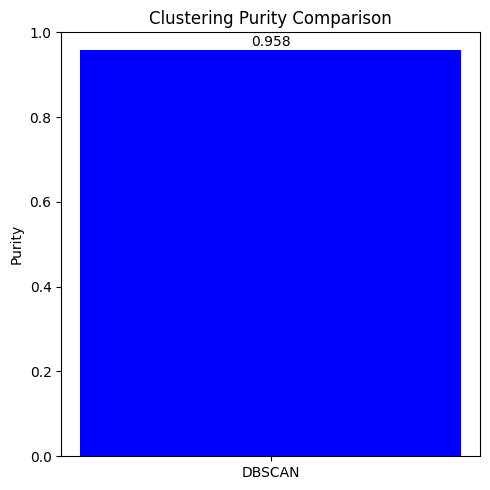

In [47]:
# 클러스터링 성능 평가
print("=== 클러스터링 알고리즘 성능 분석 ===")

# DBSCAN 성능 평가
dbscan_metrics = custom_clustering_metrics(true_labels, dbscan_labels)
print("\nDBSCAN 성능:")
print(f"  순도: {dbscan_metrics['purity']:.3f}")
print(f"  예측된 클러스터 개수: {dbscan_metrics['n_predicted_clusters']}")
print(f"  실제 클러스터 개수: {dbscan_metrics['n_true_clusters']}")

# 성능 비교 차트
methods = ['DBSCAN']
purity_scores = [dbscan_metrics['purity']]

fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5))

# 순도 비교
ax1.bar(methods, purity_scores, color=['blue', 'orange'])
ax1.set_ylabel('Purity')
ax1.set_title('Clustering Purity Comparison')
ax1.set_ylim(0, 1)
for i, v in enumerate(purity_scores):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()


### 결과 비교 시각화

In [48]:
# 모든 결과를 순차적으로 비교
print("=== 클러스터링 결과 비교 시각화 ===")
print("1. 실제 클러스터링 (Ground Truth)")
print("2. DBSCAN 결과")
print("각 창을 닫으면 다음 결과로 진행됩니다.")

# 1. Ground Truth
visualize_clustering_result(test_pcd, true_labels,
                           centroids=np.array(cluster_centers),
                           title="1. Ground Truth")

# 2. DBSCAN 결과
visualize_clustering_result(test_pcd, dbscan_labels,
                           title="2. DBSCAN Clustering Result",
                           show_centroids=False)


=== 클러스터링 결과 비교 시각화 ===
1. 실제 클러스터링 (Ground Truth)
2. DBSCAN 결과
각 창을 닫으면 다음 결과로 진행됩니다.


### 4-3. 실제 포인트 클라우드 데이터로 클러스터링

이제 실제 포인트 클라우드 데이터를 가져와 클러스터링을 적용해보겠습니다.

In [ ]:
loaded_pcd = merged_radar_pcd # 병합한 데이터

# DBSCAN 클러스터링
print("2. DBSCAN 클러스터링 수행...")
epsilon_tune = epsilon_manual  # TODO: Epsilon 값 조정
min_points_tune = min_points_manual  # TODO: 최소 포인트 개수 조정
pcd_dbscan_labels, pcd_n_clusters = custom_dbscan_clustering(
    loaded_pcd, epsilon=epsilon_tune, min_points=min_points_tune
)

print(f"DBSCAN 결과: {pcd_n_clusters}개 클러스터, {np.sum(pcd_dbscan_labels == -1)}개 노이즈")

# 결과 시각화
visualize_clustering_result(loaded_pcd, pcd_dbscan_labels,
                           title="PCD - DBSCAN Result",
                           show_centroids=False)


2. DBSCAN 클러스터링 수행...
DBSCAN 결과: 5개 클러스터, 258개 노이즈


In [51]:
loaded_pcd = o3d.io.read_point_cloud("../data/lidar_pcd/various_objects_color.ply")

# DBSCAN 클러스터링
print("2. DBSCAN 클러스터링 수행...")
epsilon_tune = epsilon_manual  # TODO: Epsilon 값 조정
min_points_tune = min_points_manual  # TODO: 최소 포인트 개수 조정
pcd_dbscan_labels, pcd_n_clusters = custom_dbscan_clustering(
    loaded_pcd, epsilon=epsilon_tune, min_points=min_points_tune
)

print(f"DBSCAN 결과: {pcd_n_clusters}개 클러스터, {np.sum(pcd_dbscan_labels == -1)}개 노이즈")

# 결과 시각화
visualize_clustering_result(loaded_pcd, pcd_dbscan_labels,
                           title="PCD - DBSCAN Result",
                           show_centroids=False)


2. DBSCAN 클러스터링 수행...
DBSCAN 결과: 1개 클러스터, 0개 노이즈
